In [68]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import pandas as pd
from bs4 import BeautifulSoup
import time
import re
from datetime import datetime
import matplotlib.pyplot as plt

In [69]:
def standardize_time_format(time_str):
    try:
        # Ensure the time string is in the format "hh:mm AM/PM"
        if re.match(r'^\d{1,2}:\d{2} [APM]{2}$', time_str):
            return datetime.strptime(time_str, "%I:%M %p").strftime("%I:%M %p")
        else:
            return "Unknown Time"  # If the time format is incorrect
    except ValueError:
        return "Unknown Time"

In [70]:
#def standardize_time_format(time_str):
    #try:
        # Try to parse the time in 12-hour format (AM/PM)
        #time_12hr = datetime.strptime(time_str, "%I:%M %p").strftime("%I:%M %p")
        #return time_12hr
    # ValueError:
        # If parsing fails, return the original string (likely already formatted)
        #return time_str

In [71]:
def parse_date_and_time(date_str, current_date = None):
    try:
        # First try to parse the 1999 format, e.g., 'SatAug 07, 1999 12:00 PM'
        try:
            date_time_parts = re.split(r'(\d{1,2}:\d{2} [APM]{2})', date_str)
            if len(date_time_parts) == 3:
                date_part = date_time_parts[0].strip()
                time_part = date_time_parts[1].strip()
            else:
                date_part = date_str.strip()
                time_part = "Unknown Time"
            
            parsed_date = datetime.strptime(date_part, "%a%b %d, %Y").strftime("%Y-%m-%d")
            return parsed_date, time_part

        except ValueError:
            pass  # Try the next format

        # Try to parse the 2000 format, e.g., 'Sun5/14/00 5:00 PM'
        try:
            date_time_parts = re.split(r'(\d{1,2}:\d{2} [APM]{2})', date_str)
            if len(date_time_parts) == 3:
                date_part = date_time_parts[0].strip()
                time_part = date_time_parts[1].strip()
            else:
                date_part = date_str.strip()
                time_part = "Unknown Time"
            
            parsed_date = datetime.strptime(date_part, "%a%m/%d/%y").strftime("%Y-%m-%d")
            return parsed_date, time_part

        except ValueError:
            pass

        try:
            date_anchor_tag = re.search(r'(\d{1,2}/\d{1,2}/\d{2})', date_str)
            time_part = re.search(r'(\d{1,2}:\d{2} [APM]{2})', date_str)
            
            if date_anchor_tag and time_part:
                date_part = date_anchor_tag.group(1).strip()
                time_part = time_part.group(1).strip()

                parsed_date = datetime.strptime(date_part, "%m/%d/%y").strftime("%Y-%m-%d")
                return parsed_date, time_part

        except ValueError:
            pass

        try:
            time_only = re.search(r'(\d{1,2}:\d{2} [APM]{2})', date_str)
            if time_only and current_date:
                return current_date, time_only.group(1).strip()

        except ValueError:
            pass

        # If none of the formats match, return unknown
        return "Unknown Date", "Unknown Time"

    except Exception as e:
        print(f"Error parsing date: {e}")
        return "Unknown Date", "Unknown Time"
    
    # Function to generate match ID
def generate_match_id(year, match_number):
    season_code = f"{str(year)[-2:]}{str(year + 1)[-2:]}"
    base_match_id = int(season_code + "01")
    return base_match_id + match_number

In [72]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

In [73]:
start_year = 1992
end_year = 2023

In [74]:
matches_data = []

In [75]:
for year in range(start_year, end_year + 1):
    try:
        season = f"{year}/{year+1}"  # Define the season as a string
        print(f"Scraping season {season}...")
        season_url = f"https://www.transfermarkt.com/premier-league/gesamtspielplan/wettbewerb/GB1/saison_id/{year}"
        driver.get(season_url)
        time.sleep(10)

        soup = BeautifulSoup(driver.page_source, 'html.parser')
        matchday_boxes = soup.find_all("div", class_="box")

        if not matchday_boxes:
            print(f"Warning: No matchday boxes found for season {season}.")
            continue

        match_count = 0  # Track matches within the season
        for matchday_number, matchday_box in enumerate(matchday_boxes, start=1):
            matchday_table = matchday_box.find("table")
            match_rows = matchday_table.find_all("tr") if matchday_table else []

            current_date = None
            #current_time = None
    
            for i, match in enumerate(match_rows):
        # If the row contains only one <td>, it's likely the date row
                if len(match.find_all("td")) == 1:
                    current_date_time = match.get_text(strip=True)
            #print(f"Detected date row: {current_date_time}")
            
            # Extract both date and time
                    parsed_date, parsed_time = parse_date_and_time(current_date_time, current_date)
                    if parsed_date != "Unknown Date":
                        current_date = parsed_date
                    #if parsed_time != "Unknown Time":
                        #current_time = parsed_time
                    continue  # Move to the next row for match data

        # Ensure that we have a valid current_date before continuing
                if not current_date:
                    #print(f"Skipping row due to missing date: {match}")
                    continue

        # Extract match data (home team, away team, and score)
                home_team_element = match.find("td", class_="text-right no-border-rechts hauptlink")
                away_team_element = match.find("td", class_="no-border-links hauptlink")

                home_team = home_team_element.get_text(strip=True) if home_team_element else "Not available"
                away_team = away_team_element.get_text(strip=True) if away_team_element else "Not available"

        # Clean up team names
                home_team = re.sub(r"\(\d+\.\)\s*", "", home_team)
                away_team = re.sub(r"\(\d+\.\)\s*", "", away_team)

        # Extract Score
                score_element = match.find("a", class_="ergebnis-link")
                score = score_element.get_text(strip=True) if score_element else "Not available"
                score_home, score_away = score.split(":") if ":" in score else ("Not available", "Not available")

        # Print the match details
        #print(f"Match: {home_team} vs {away_team} - {score_home}:{score_away} on {current_date} at {current_time}")
        
                #valid_time = standardize_time_format(current_time)
                match_id = generate_match_id(year, match_count)
                match_count += 1

        # Store match data in a dictionary
                match_data = {
                    "Match_ID": match_id,
                    "Match_Day": matchday_number,
                    "Date": current_date,  # Using the parsed date
                    #"Time": valid_time,  # Using the valid time
                    "Home_Team": home_team,
                    "Score_Home": score_home,
                    "Away_Team": away_team,
                    "Score_Away": score_away,
                    "Season": season
                }

                matches_data.append(match_data)
                
    except Exception as e:
        continue

Scraping season 1992/1993...


Scraping season 1993/1994...
Scraping season 1994/1995...
Scraping season 1995/1996...
Scraping season 1996/1997...
Scraping season 1997/1998...
Scraping season 1998/1999...
Scraping season 1999/2000...
Scraping season 2000/2001...
Scraping season 2001/2002...
Scraping season 2002/2003...
Scraping season 2003/2004...
Scraping season 2004/2005...
Scraping season 2005/2006...
Scraping season 2006/2007...
Scraping season 2007/2008...
Scraping season 2008/2009...
Scraping season 2009/2010...
Scraping season 2010/2011...
Scraping season 2011/2012...
Scraping season 2012/2013...
Scraping season 2013/2014...
Scraping season 2014/2015...
Scraping season 2015/2016...
Scraping season 2016/2017...
Scraping season 2017/2018...
Scraping season 2018/2019...
Scraping season 2019/2020...
Scraping season 2020/2021...
Scraping season 2021/2022...
Scraping season 2022/2023...
Scraping season 2023/2024...


In [76]:
df = pd.DataFrame(matches_data)

In [77]:
df['Match_Day'] -= 1

In [78]:
#df['Time'] = df['Time'].apply(standardize_time_format)

In [79]:
df.head(12)

,Match_ID,Match_Day,Date,Home_Team,Score_Home,Away_Team,Score_Away,Season
0,929301,1,1992-08-15,Arsenal,2,Norwich,4,1992/1993
1,929302,1,1992-08-15,Chelsea,1,Oldham Athletic,1,1992/1993
2,929303,1,1992-08-15,Coventry,2,Middlesbrough,1,1992/1993
3,929304,1,1992-08-15,Crystal Palace,3,Blackburn,3,1992/1993
4,929305,1,1992-08-15,Everton,1,Sheff Wed,1,1992/1993
5,929306,1,1992-08-15,Ipswich,1,Aston Villa,1,1992/1993
6,929307,1,1992-08-15,Leeds,2,Wimbledon FC,1,1992/1993
7,929308,1,1992-08-15,Sheff Utd,2,Man Utd,1,1992/1993
8,929309,1,1992-08-15,Southampton,0,Tottenham,0,1992/1993
9,929310,1,1992-08-16,Nottm Forest,1,Liverpool,0,1992/1993


In [80]:
df.tail()

,Match_ID,Match_Day,Date,Home_Team,Score_Home,Away_Team,Score_Away,Season
11948,232776,38,2024-05-19,Crystal Palace,5,Aston Villa,0,2023/2024
11949,232777,38,2024-05-19,Liverpool,2,Wolves,0,2023/2024
11950,232778,38,2024-05-19,Luton,2,Fulham,4,2023/2024
11951,232779,38,2024-05-19,Man City,3,West Ham,1,2023/2024
11952,232780,38,2024-05-19,Sheff Utd,0,Tottenham,3,2023/2024


In [81]:
df.loc[df['Date']=='Unknown Date']

,Match_ID,Match_Day,Date,Home_Team,Score_Home,Away_Team,Score_Away,Season


In [82]:
df2 = pd.read_csv("Manager History.csv")

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11953 entries, 0 to 11952
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Match_ID    11953 non-null  int64 
 1   Match_Day   11953 non-null  int64 
 2   Date        11953 non-null  object
 3   Home_Team   11953 non-null  object
 4   Score_Home  11953 non-null  object
 5   Away_Team   11953 non-null  object
 6   Score_Away  11953 non-null  object
 7   Season      11953 non-null  object
dtypes: int64(2), object(6)
memory usage: 747.2+ KB


In [84]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487 entries, 0 to 486
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    487 non-null    int64  
 1   Manager_ID    487 non-null    object 
 2   Team_ID       487 non-null    object 
 3   Team_Name     487 non-null    object 
 4   Manager_Name  487 non-null    object 
 5   Appointed     487 non-null    object 
 6   End of Time   487 non-null    object 
 7   Time in Post  487 non-null    object 
 8   Matches       487 non-null    int64  
 9   Wins          487 non-null    float64
 10  Draws         487 non-null    float64
 11  Losses        487 non-null    float64
 12  PPG           487 non-null    float64
 13  Points        487 non-null    float64
 14  Wins_Ratio    487 non-null    float64
dtypes: float64(6), int64(2), object(7)
memory usage: 57.2+ KB


In [85]:
df2['Appointed'] = pd.to_datetime(df2['Appointed'], errors='coerce')
df2['End of Time'] = pd.to_datetime(df2['End of Time'].replace('Still in job', pd.Timestamp.today().date()), errors='coerce')

In [86]:
df.replace({'Man City': 'Manchester City', 'Man Utd': 'Manchester United', 'Sheff Utd': 'Sheffield United', 'Sheff Wed': 'Sheffield Wednesday', 'Nottm Forest': 'Nottingham Forest', 'QPR': 'Queens Park Rangers', 'Wolves': 'Wolverhampton Wanderers', 'West Brom': 'West Bromwich Albion'}, inplace=True)

In [87]:
def match_and_replace_team_name(df_team_name, df2):
    # Try exact match first
    for idx, row in df2.iterrows():
        if df_team_name == row['Team_Name']:
            return row['Team_Name'], row['Team_ID']
    
    # If no exact match, try matching the first word of the team name
    df_team_first_word = df_team_name.split()[0]
    for idx, row in df2.iterrows():
        team_first_word = row['Team_Name'].split()[0]
        if df_team_first_word == team_first_word:
            return row['Team_Name'], row['Team_ID']
    
    # If no match, return the original team name with None as Team_ID
    return df_team_name, None

# Apply the matching function to correct team names and get Team_ID for home and away teams
df['Home_Team_Name'], df['Home_Team_ID'] = zip(*df['Home_Team'].apply(lambda x: match_and_replace_team_name(x, df2)))
df['Away_Team_Name'], df['Away_Team_ID'] = zip(*df['Away_Team'].apply(lambda x: match_and_replace_team_name(x, df2)))

# Optional: If you want to rename the updated columns back to 'Home_Team' and 'Away_Team' for consistency
#df.rename(columns={'Home_Team_Name': 'Home_Team', 'Away_Team_Name': 'Away_Team'}, inplace=True)

In [88]:
df.drop(columns=['Home_Team', 'Away_Team'], inplace=True)
df.rename(columns={'Home_Team_Name': 'Home_Team', 'Away_Team_Name': 'Away_Team'}, inplace=True)
df = df[['Match_ID', 'Match_Day', 'Date', 'Home_Team', 'Home_Team_ID', 'Score_Home', 'Away_Team', 'Away_Team_ID', 'Score_Away', 'Season']]

In [89]:
df.head()

,Match_ID,Match_Day,Date,Home_Team,Home_Team_ID,Score_Home,Away_Team,Away_Team_ID,Score_Away,Season
0,929301,1,1992-08-15,Arsenal,ARS,2,Norwich City,NCI,4,1992/1993
1,929302,1,1992-08-15,Chelsea,CHE,1,Oldham Athletic,OAT,1,1992/1993
2,929303,1,1992-08-15,Coventry City,COV,2,Middlesbrough,MID,1,1992/1993
3,929304,1,1992-08-15,Crystal Palace,CPA,3,Blackburn Rovers,BRO,3,1992/1993
4,929305,1,1992-08-15,Everton,EVE,1,Sheffield Wednesday,SWE,1,1992/1993


In [90]:
print(df['Home_Team'].unique())

['Arsenal' 'Chelsea' 'Coventry City' 'Crystal Palace' 'Everton'
 'Ipswich Town' 'Leeds United' 'Sheffield United' 'Southampton'
 'Nottingham Forest' 'Manchester City' 'Blackburn Rovers' 'Wimbledon'
 'Aston Villa' 'Liverpool' 'Manchester United' 'Middlesbrough'
 'Norwich City' 'Oldham Athletic' 'Queens Park Rangers'
 'Sheffield Wednesday' 'Tottenham Hotspur' 'Newcastle United'
 'West Ham United' 'Swindon Town' 'Leicester City' 'Bolton Wanderers'
 'Derby County' 'Sunderland' 'Barnsley' 'Charlton Athletic' 'Watford'
 'Bradford City' 'Fulham' 'Birmingham City' 'West Bromwich Albion'
 'Portsmouth' 'Wolverhampton Wanderers' 'Wigan Athletic' 'Reading'
 'Hull City' 'Stoke City' 'Burnley' 'Blackpool' 'Swansea City'
 'Cardiff City' 'Bournemouth' 'Brighton & Hove Albion' 'Huddersfield Town'
 'Brentford' 'Luton Town']


In [91]:
def find_manager(team_name, match_date, df_managers):
    df_team_managers = df_managers[df_managers['Team_Name'] == team_name]
    
    manager_row = df_team_managers[
        (df_team_managers['Appointed'] <= match_date) &
        (df_team_managers['End of Time'] >= match_date)
    ]
    
    if not manager_row.empty:
        manager = manager_row.iloc[0]
        return manager['Manager_Name'], manager['Manager_ID']
    else:
        return "Unknown Manager", "Unknown ID"

In [92]:
df['Manager_Home'] = ''
df['Manager_Away'] = ''
df['Manager_Home_ID'] = ''
df['Manager_Away_ID'] = ''

In [93]:
for idx, match in df.iterrows():
    match_date = pd.to_datetime(match['Date'], errors='coerce')
    
    manager_home, manager_home_id = find_manager(match['Home_Team'], match_date, df2)
    
    manager_away, manager_away_id = find_manager(match['Away_Team'], match_date, df2)
    
    df.at[idx, 'Manager_Home'] = manager_home
    df.at[idx, 'Manager_Away'] = manager_away
    df.at[idx, 'Manager_Home_ID'] = manager_home_id
    df.at[idx, 'Manager_Away_ID'] = manager_away_id

In [94]:
df.head()

,Match_ID,Match_Day,Date,Home_Team,Home_Team_ID,Score_Home,Away_Team,Away_Team_ID,Score_Away,Season,Manager_Home,Manager_Away,Manager_Home_ID,Manager_Away_ID
0,929301,1,1992-08-15,Arsenal,ARS,2,Norwich City,NCI,4,1992/1993,George Graham,Mike Walker,GGARS12,MWNCI10
1,929302,1,1992-08-15,Chelsea,CHE,1,Oldham Athletic,OAT,1,1992/1993,Ian Porterfield,Joe Royle,IPCHE14,JROAT08
2,929303,1,1992-08-15,Coventry City,COV,2,Middlesbrough,MID,1,1992/1993,Bobby Gould,Lennie Lawrence,BGCOV10,LLMID14
3,929304,1,1992-08-15,Crystal Palace,CPA,3,Blackburn Rovers,BRO,3,1992/1993,Steve Coppell,Sir Kenny Dalglish,SCCPA12,SKBRO16
4,929305,1,1992-08-15,Everton,EVE,1,Sheffield Wednesday,SWE,1,1992/1993,Howard Kendall,Trevor Francis,HKEVE13,TFSWE13


In [95]:
df2.loc[df2['Team_Name']=='Norwich City']

,Unnamed: 0,Manager_ID,Team_ID,Team_Name,Manager_Name,Appointed,End of Time,Time in Post,Matches,Wins,Draws,Losses,PPG,Points,Wins_Ratio
353,353,DSNCI09,NCI,Norwich City,Dean Smith,2021-11-15,2022-12-27,01 year 01 month 12 days,56,17.0,10.0,29.0,1.09,61.0,0.30
354,354,DFNCI11,NCI,Norwich City,Daniel Farke,2017-07-01,2021-11-06,04 years 04 months 06 days,208,88.0,47.0,73.0,1.50,311.0,0.42
355,355,ANNCI08,NCI,Norwich City,Alex Neil,2015-01-09,2017-03-10,02 years 02 months 01 day,108,45.0,21.0,42.0,1.44,156.0,0.42
356,356,NANCI09,NCI,Norwich City,Neil Adams,2014-04-06,2015-01-05,08 months 30 days,32,11.0,8.0,13.0,1.28,41.0,0.34
357,357,CHNCI12,NCI,Norwich City,Chris Hughton,2012-06-07,2014-04-06,01 year 09 months 30 days,82,24.0,23.0,35.0,1.16,95.0,0.29
358,358,PLNCI11,NCI,Norwich City,Paul Lambert,2009-08-19,2012-06-01,02 years 09 months 13 days,140,71.0,33.0,36.0,1.76,246.0,0.51
359,359,NWNCI16,NCI,Norwich City,Nigel Worthington,2001-01-02,2006-10-01,05 years 08 months 29 days,271,111.0,58.0,102.0,1.44,391.0,0.41
360,360,GMNCI10,NCI,Norwich City,Gary Megson,1995-04-09,1995-06-30,02 months 21 days,0,0.0,0.0,0.0,0.00,0.0,0.00
361,361,JDNCI10,NCI,Norwich City,John Deehan,1994-01-07,1995-04-09,01 year 03 months 02 days,59,12.0,23.0,24.0,1.00,59.0,0.20
362,362,MWNCI10,NCI,Norwich City,Mike Walker,1992-07-01,1994-01-06,01 year 06 months 06 days,74,33.0,19.0,22.0,1.59,118.0,0.45


In [96]:
df2.drop(columns=['Unnamed: 0'], inplace=True)

In [97]:
df2.head()

,Manager_ID,Team_ID,Team_Name,Manager_Name,Appointed,End of Time,Time in Post,Matches,Wins,Draws,Losses,PPG,Points,Wins_Ratio
0,EtMUN10,MUN,Manchester United,Erik ten Hag,2022-07-01,2024-10-01,02 years 03 months 00 days,123,71.0,17.0,35.0,1.87,230.0,0.58
1,RRMUN12,MUN,Manchester United,Ralf Rangnick,2021-12-03,2022-05-31,05 months 28 days,29,11.0,9.0,9.0,1.45,42.0,0.38
2,MCMUN14,MUN,Manchester United,Michael Carrick,2021-11-21,2021-12-03,12 days,3,2.0,1.0,0.0,2.33,7.0,0.67
3,OGMUN17,MUN,Manchester United,Ole Gunnar Solskjaer,2019-03-28,2021-11-21,02 years 07 months 24 days,149,78.0,33.0,38.0,1.79,267.0,0.52
4,OGMUN17,MUN,Manchester United,Ole Gunnar Solskjaer,2018-12-19,2019-03-28,03 months 09 days,19,14.0,2.0,3.0,2.32,44.0,0.74


In [98]:
df = df[['Match_ID', 'Match_Day', 'Date', 'Home_Team', 'Home_Team_ID', 'Manager_Home', 'Manager_Home_ID', 'Score_Home', 'Score_Away', 'Away_Team', 'Away_Team_ID', 'Manager_Away', 'Manager_Away_ID', 'Season']]
df.head()

,Match_ID,Match_Day,Date,Home_Team,Home_Team_ID,Manager_Home,Manager_Home_ID,Score_Home,Score_Away,Away_Team,Away_Team_ID,Manager_Away,Manager_Away_ID,Season
0,929301,1,1992-08-15,Arsenal,ARS,George Graham,GGARS12,2,4,Norwich City,NCI,Mike Walker,MWNCI10,1992/1993
1,929302,1,1992-08-15,Chelsea,CHE,Ian Porterfield,IPCHE14,1,1,Oldham Athletic,OAT,Joe Royle,JROAT08,1992/1993
2,929303,1,1992-08-15,Coventry City,COV,Bobby Gould,BGCOV10,2,1,Middlesbrough,MID,Lennie Lawrence,LLMID14,1992/1993
3,929304,1,1992-08-15,Crystal Palace,CPA,Steve Coppell,SCCPA12,3,3,Blackburn Rovers,BRO,Sir Kenny Dalglish,SKBRO16,1992/1993
4,929305,1,1992-08-15,Everton,EVE,Howard Kendall,HKEVE13,1,1,Sheffield Wednesday,SWE,Trevor Francis,TFSWE13,1992/1993


In [99]:
df.loc[df['Manager_Home']=='Unknown Manager']

,Match_ID,Match_Day,Date,Home_Team,Home_Team_ID,Manager_Home,Manager_Home_ID,Score_Home,Score_Away,Away_Team,Away_Team_ID,Manager_Away,Manager_Away_ID,Season
2955,223,13,2000-11-11,Bradford City,BRA,Unknown Manager,Unknown ID,0,1,Everton,EVE,Walter Smith,WSEVE11,2000/2001
4229,30657,26,2004-02-21,Southampton,SOU,Unknown Manager,Unknown ID,3,3,Everton,EVE,David Moyes,DMEVE10,2003/2004
6471,91219,22,2010-01-17,Bolton Wanderers,BWA,Unknown Manager,Unknown ID,0,2,Arsenal,ARS,Arsene Wenger,AWARS12,2009/2010
8694,151762,17,2015-12-19,Chelsea,CHE,Unknown Manager,Unknown ID,3,1,Sunderland,SUN,Sam Allardyce,SASUN12,2015/2016


In [100]:
df.loc[df['Manager_Away']=='Unknown Manager']

,Match_ID,Match_Day,Date,Home_Team,Home_Team_ID,Manager_Home,Manager_Home_ID,Score_Home,Score_Away,Away_Team,Away_Team_ID,Manager_Away,Manager_Away_ID,Season
648,949642,14,1994-11-19,Tottenham Hotspur,THO,Gerry Francis,GFTHO12,3,4,Aston Villa,AVI,Unknown Manager,Unknown ID,1994/1995
2968,236,14,2000-11-18,Derby County,DCO,Jim Smith,JSDCO08,2,0,Bradford City,BRA,Unknown Manager,Unknown ID,2000/2001
3209,477,38,2001-05-19,Middlesbrough,MID,Bryan Robson,BRMID11,2,1,West Ham United,WHA,Unknown Manager,Unknown ID,2000/2001
4236,30664,27,2004-02-28,Blackburn Rovers,BRO,Graeme Souness,GSBRO13,1,1,Southampton,SOU,Unknown Manager,Unknown ID,2003/2004
5492,61080,38,2007-05-13,Watford,WAT,Aidy Boothroyd,ABWAT13,1,1,Newcastle United,NUN,Unknown Manager,Unknown ID,2006/2007
7515,121423,13,2012-11-24,Manchester United,MUN,Sir Alex Ferguson,SAMUN15,3,1,Queens Park Rangers,QPA,Unknown Manager,Unknown ID,2012/2013


In [101]:
df2.loc[df2['Team_Name']=='Bradford City']

,Manager_ID,Team_ID,Team_Name,Manager_Name,Appointed,End of Time,Time in Post,Matches,Wins,Draws,Losses,PPG,Points,Wins_Ratio
477,JJBRA12,BRA,Bradford City,Jim Jefferies,2000-11-20,2001-12-24,01 year 01 month 04 days,53,15.0,12.0,26.0,1.08,57.0,0.28
478,CHBRA14,BRA,Bradford City,Chris Hutchings,2000-07-01,2000-11-06,04 months 06 days,19,5.0,4.0,10.0,1.00,19.0,0.26
479,PJBRA10,BRA,Bradford City,Paul Jewell,1998-01-06,2000-06-30,02 years 05 months 24 days,110,42.0,23.0,45.0,1.35,149.0,0.38


In [102]:
def update_manager_info(df, row_index, manager_name, home_or_away):
    """
    Updates the manager name and manager ID for either the home or away manager.

    Args:
        df (pd.DataFrame): The dataframe containing the match information.
        row_index (int): The index of the row where the update should occur.
        manager_name (str): The manager name to replace 'Unknown Manager'.
        home_or_away (str): Specify 'home' for Home_Team or 'away' for Away_Team.
    """
    # Split the manager name to extract first and last names
    first_name, last_name = manager_name.split()
    
    # Determine whether it's a home or away team update and get the corresponding team ID
    if home_or_away == 'home':
        team_id = df.at[row_index, 'Home_Team_ID']
        manager_col = 'Manager_Home'
        manager_id_col = 'Manager_Home_ID'
    elif home_or_away == 'away':
        team_id = df.at[row_index, 'Away_Team_ID']
        manager_col = 'Manager_Away'
        manager_id_col = 'Manager_Away_ID'
    else:
        raise ValueError("The argument 'home_or_away' must be either 'home' or 'away'.")
    
    # Calculate the number of letters in the manager's full name
    num_letters = len(manager_name.replace(" ", ""))
    
    # Generate the Manager ID
    manager_id = f"{first_name[0]}{last_name[0]}{team_id}{num_letters}"
    
    # Update the manager name and manager ID in the dataframe
    df.at[row_index, manager_col] = manager_name
    df.at[row_index, manager_id_col] = manager_id

    return df


In [103]:
df2.loc[df2['Team_Name']=='Southampton']

,Manager_ID,Team_ID,Team_Name,Manager_Name,Appointed,End of Time,Time in Post,Matches,Wins,Draws,Losses,PPG,Points,Wins_Ratio
176,RSSOU11,SOU,Southampton,Ruben Selles,2023-02-24,2023-06-30,04 months 06 days,16,1.0,4.0,11.0,0.44,7.0,0.06
177,RSSOU11,SOU,Southampton,Ruben Selles,2023-02-13,2023-02-23,10 days,1,1.0,0.0,0.0,3.00,3.0,1.00
178,NJSOU11,SOU,Southampton,Nathan Jones,2022-11-10,2023-02-12,03 months 02 days,14,5.0,0.0,9.0,1.07,15.0,0.36
179,RSSOU11,SOU,Southampton,Ruben Selles,2022-11-08,2022-11-09,01 day,1,1.0,0.0,0.0,3.00,3.0,1.00
180,RHSOU15,SOU,Southampton,Ralph Hasenhuttl,2018-12-06,2022-11-07,03 years 11 months 01 day,173,60.0,38.0,75.0,1.26,218.0,0.35
181,KDSOU11,SOU,Southampton,Kelvin Davis,2018-12-03,2018-12-05,02 days,1,0.0,0.0,1.0,0.00,0.0,0.00
182,MHSOU10,SOU,Southampton,Mark Hughes,2018-03-14,2018-12-03,08 months 19 days,27,6.0,8.0,13.0,0.96,26.0,0.22
183,MPSOU18,SOU,Southampton,Mauricio Pellegrino,2017-07-01,2018-03-12,08 months 09 days,34,8.0,13.0,13.0,1.09,37.0,0.24
184,CPSOU10,SOU,Southampton,Claude Puel,2016-07-01,2017-06-14,11 months 14 days,53,20.0,13.0,20.0,1.38,73.0,0.38
185,RKSOU12,SOU,Southampton,Ronald Koeman,2014-07-01,2016-06-30,01 year 11 months 30 days,91,44.0,17.0,30.0,1.64,149.0,0.48


In [104]:
df2.loc[df2['Team_Name']=='Bolton Wanderers']

,Manager_ID,Team_ID,Team_Name,Manager_Name,Appointed,End of Time,Time in Post,Matches,Wins,Draws,Losses,PPG,Points,Wins_Ratio
302,OCBWA09,BWA,Bolton Wanderers,Owen Coyle,2010-01-20,2012-10-09,02 years 08 months 19 days,125,42.0,24.0,59.0,1.20,150.0,0.34
303,SWBWA11,BWA,Bolton Wanderers,Steve Wigley,2009-12-30,2010-01-08,09 days,1,1.0,0.0,0.0,3.00,3.0,1.00
304,CEBWA10,BWA,Bolton Wanderers,Chris Evans,2009-12-30,2010-01-08,09 days,0,0.0,0.0,0.0,0.00,0.0,0.00
305,GMBWA10,BWA,Bolton Wanderers,Gary Megson,2007-10-25,2009-12-30,02 years 02 months 05 days,99,27.0,27.0,45.0,1.09,108.0,0.27
306,AKBWA10,BWA,Bolton Wanderers,Archie Knox,2007-10-18,2007-10-25,07 days,1,0.0,0.0,1.0,0.00,0.0,0.00
307,SLBWA08,BWA,Bolton Wanderers,Sammy Lee,2007-04-30,2007-10-17,05 months 17 days,14,3.0,4.0,7.0,0.93,13.0,0.21
308,SABWA12,BWA,Bolton Wanderers,Sam Allardyce,1999-10-19,2007-04-30,07 years 06 months 11 days,365,151.0,100.0,114.0,1.52,553.0,0.41
309,CTBWA09,BWA,Bolton Wanderers,Colin Todd,1996-01-02,1999-09-22,03 years 08 months 20 days,162,70.0,47.0,45.0,1.59,257.0,0.43
310,RMBWA12,BWA,Bolton Wanderers,Roy McFarland,1995-07-11,1996-01-07,05 months 27 days,24,3.0,5.0,16.0,0.58,14.0,0.12


In [105]:
df = update_manager_info(df, 2955, "Stuart McCall", 'home')
df = update_manager_info(df, 4229, "Gordon Strachan", 'home')
df = update_manager_info(df, 6471, "Owen Coyle", 'home')
df = update_manager_info(df, 8694, "Steve Holland", 'home')
df = update_manager_info(df, 648, "Jim Barron", 'away')
df = update_manager_info(df, 2968, "Stuart McCall", 'away')
df = update_manager_info(df, 3209, "Glenn Roeder", 'away')
df = update_manager_info(df, 4236, "Paul Sturrock", 'away')
df = update_manager_info(df, 5492, "Nigel Pearson", 'away')
df = update_manager_info(df, 7515, "Mark Bowen", 'away')


In [106]:
df.loc[df['Manager_Away']=='Mark Bowen']

,Match_ID,Match_Day,Date,Home_Team,Home_Team_ID,Manager_Home,Manager_Home_ID,Score_Home,Score_Away,Away_Team,Away_Team_ID,Manager_Away,Manager_Away_ID,Season
7515,121423,13,2012-11-24,Manchester United,MUN,Sir Alex Ferguson,SAMUN15,3,1,Queens Park Rangers,QPA,Mark Bowen,MBQPA9,2012/2013


In [107]:
def count_manager_wins(df, manager_name, manager_id):
    """
    Count the number of wins for a given manager across different seasons.
    
    Args:
        df (pd.DataFrame): The dataframe containing match data.
        manager_name (str): The name of the manager.
        manager_id (str): The ID of the manager.
    
    Returns:
        pd.DataFrame: A dataframe with the seasons and corresponding win counts.
    """
    # Filter the dataframe for matches where the manager is either the home or away manager
    manager_home_matches = df[df['Manager_Home'] == manager_name]
    manager_away_matches = df[df['Manager_Away'] == manager_name]
    
    # Count wins when the manager is the home manager and the home team won
    home_wins = manager_home_matches[manager_home_matches['Score_Home'] > manager_home_matches['Score_Away']]
    home_wins_by_season = home_wins.groupby('Season')['Match_ID'].count().reset_index()
    home_wins_by_season.columns = ['Season', 'Wins']

    # Count wins when the manager is the away manager and the away team won
    away_wins = manager_away_matches[manager_away_matches['Score_Away'] > manager_away_matches['Score_Home']]
    away_wins_by_season = away_wins.groupby('Season')['Match_ID'].count().reset_index()
    away_wins_by_season.columns = ['Season', 'Wins']

    # Combine home and away wins by season
    total_wins_by_season = pd.concat([home_wins_by_season, away_wins_by_season]).groupby('Season').sum().reset_index()

    return total_wins_by_season

In [108]:
saf_name = "Sir Alex Ferguson"
saf_id = "SAMUN15"
wins_by_season = count_manager_wins(df, saf_name, saf_id)

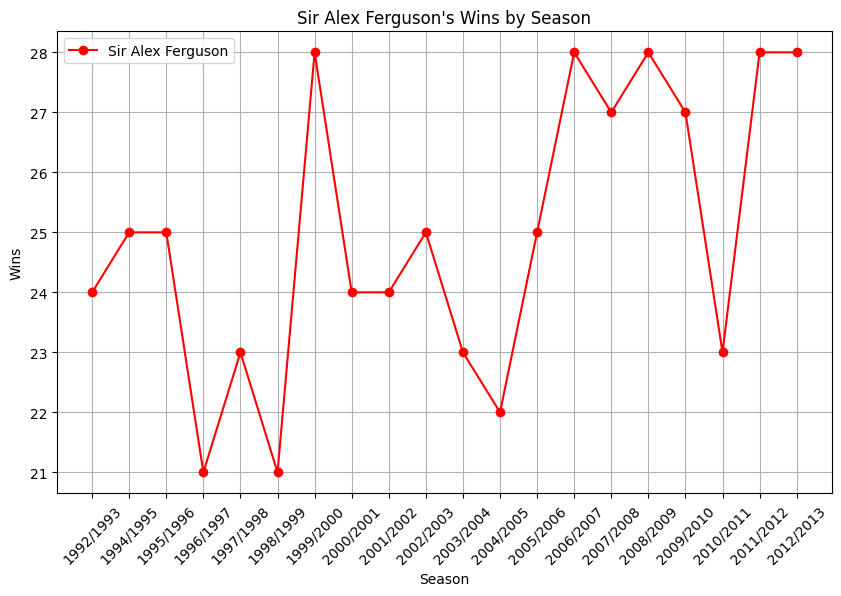

In [109]:
plt.figure(figsize=(10, 6))
plt.plot(wins_by_season['Season'], wins_by_season['Wins'], marker='o', color='r', label=saf_name)
plt.title(f"{saf_name}'s Wins by Season")
plt.xlabel('Season')
plt.ylabel('Wins')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

In [110]:
pep_name = "Pep Guardiola"
pep_id = "PCMCI12"
wins_by_season_pep = count_manager_wins(df, pep_name, pep_id)

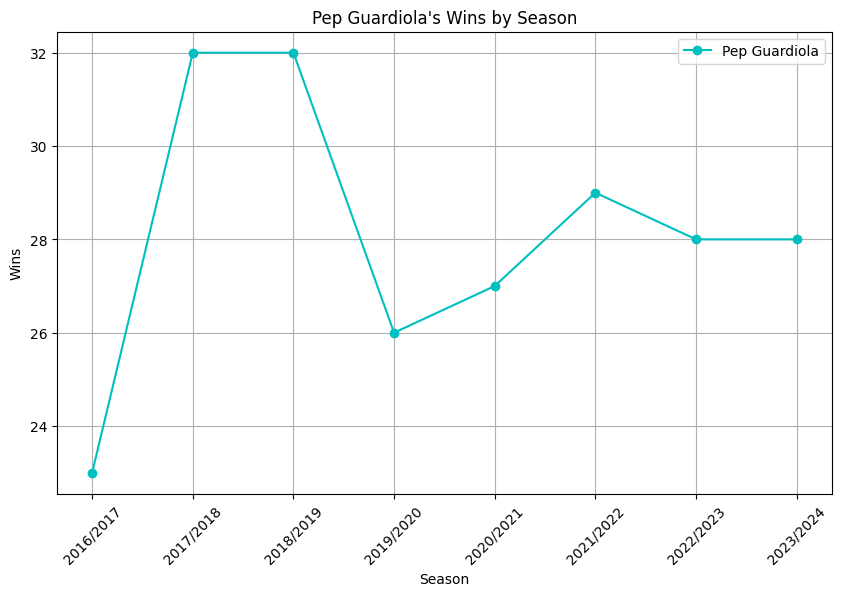

In [111]:
plt.figure(figsize=(10, 6))
plt.plot(wins_by_season_pep['Season'], wins_by_season_pep['Wins'], marker='o', color='c', label=pep_name)
plt.title(f"{pep_name}'s Wins by Season")
plt.xlabel('Season')
plt.ylabel('Wins')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

In [112]:
def new_count_manager_wins(df, manager_name):
    """
    Count the number of wins for a given manager across different seasons.
    
    Args:
        df (pd.DataFrame): The dataframe containing match data.
        manager_name (str): The name of the manager.
    
    Returns:
        pd.DataFrame: A dataframe with the seasons and corresponding win counts.
    """
    # Filter the dataframe for matches where the manager is either the home or away manager
    manager_home_matches = df[df['Manager_Home'] == manager_name]
    manager_away_matches = df[df['Manager_Away'] == manager_name]
    
    # Count wins when the manager is the home manager and the home team won
    home_wins = manager_home_matches[manager_home_matches['Score_Home'] > manager_home_matches['Score_Away']]
    home_wins_by_season = home_wins.groupby('Season')['Match_ID'].count().reset_index()
    home_wins_by_season.columns = ['Season', 'Wins']

    # Count wins when the manager is the away manager and the away team won
    away_wins = manager_away_matches[manager_away_matches['Score_Away'] > manager_away_matches['Score_Home']]
    away_wins_by_season = away_wins.groupby('Season')['Match_ID'].count().reset_index()
    away_wins_by_season.columns = ['Season', 'Wins']

    # Combine home and away wins by season
    total_wins_by_season = pd.concat([home_wins_by_season, away_wins_by_season]).groupby('Season').sum().reset_index()

    return total_wins_by_season

In [113]:
manager_1_name = "Mikel Arteta"
manager_2_name = "Arsene Wenger"

wins_by_season_manager_1 = new_count_manager_wins(df, manager_1_name)
wins_by_season_manager_2 = new_count_manager_wins(df, manager_2_name)

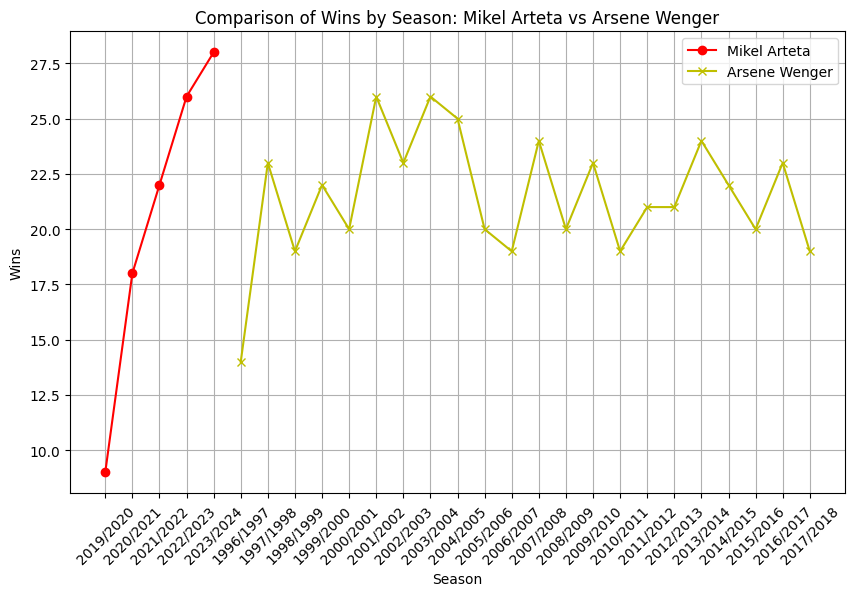

In [114]:
plt.figure(figsize=(10, 6))

# Plot Manager 1's wins
plt.plot(wins_by_season_manager_1['Season'], wins_by_season_manager_1['Wins'], marker='o', color='r', label=manager_1_name)

# Plot Manager 2's wins
plt.plot(wins_by_season_manager_2['Season'], wins_by_season_manager_2['Wins'], marker='x', color='y', label=manager_2_name)

# Adding titles and labels
plt.title(f"Comparison of Wins by Season: {manager_1_name} vs {manager_2_name}")
plt.xlabel('Season')
plt.ylabel('Wins')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()


In [115]:
df.to_csv('EPL Matches 1992_1993_2023_2024.csv')

In [116]:
df.head()

,Match_ID,Match_Day,Date,Home_Team,Home_Team_ID,Manager_Home,Manager_Home_ID,Score_Home,Score_Away,Away_Team,Away_Team_ID,Manager_Away,Manager_Away_ID,Season
0,929301,1,1992-08-15,Arsenal,ARS,George Graham,GGARS12,2,4,Norwich City,NCI,Mike Walker,MWNCI10,1992/1993
1,929302,1,1992-08-15,Chelsea,CHE,Ian Porterfield,IPCHE14,1,1,Oldham Athletic,OAT,Joe Royle,JROAT08,1992/1993
2,929303,1,1992-08-15,Coventry City,COV,Bobby Gould,BGCOV10,2,1,Middlesbrough,MID,Lennie Lawrence,LLMID14,1992/1993
3,929304,1,1992-08-15,Crystal Palace,CPA,Steve Coppell,SCCPA12,3,3,Blackburn Rovers,BRO,Sir Kenny Dalglish,SKBRO16,1992/1993
4,929305,1,1992-08-15,Everton,EVE,Howard Kendall,HKEVE13,1,1,Sheffield Wednesday,SWE,Trevor Francis,TFSWE13,1992/1993


In [117]:
df2.loc[df2['Team_Name']=='Birmingham City']

,Manager_ID,Team_ID,Team_Name,Manager_Name,Appointed,End of Time,Time in Post,Matches,Wins,Draws,Losses,PPG,Points,Wins_Ratio
426,AMBCI11,BCI,Birmingham City,Alex McLeish,2007-11-27,2011-06-12,03 years 06 months 16 days,168,63.0,50.0,55.0,1.42,239.0,0.38
427,EBBCI09,BCI,Birmingham City,Eric Black,2007-11-23,2007-11-27,04 days,1,0.0,0.0,1.0,0.00,0.0,0.00
428,EBBCI09,BCI,Birmingham City,Eric Black,2007-11-23,2007-11-27,04 days,1,0.0,0.0,1.0,0.00,0.0,0.00
429,EBBCI09,BCI,Birmingham City,Eric Black,2007-11-23,2007-11-27,04 days,1,0.0,0.0,1.0,0.00,0.0,0.00
430,EBBCI09,BCI,Birmingham City,Eric Black,2007-11-23,2007-11-27,04 days,1,0.0,0.0,1.0,0.00,0.0,0.00
431,KSBCI17,BCI,Birmingham City,Kristjaan Speakman,2006-07-01,2010-12-31,04 years 06 months 00 days,1,0.0,1.0,0.0,1.00,1.0,0.00
432,SBBCI10,BCI,Birmingham City,Steve Bruce,2001-12-12,2007-11-18,05 years 11 months 06 days,264,100.0,65.0,99.0,1.38,365.0,0.38


In [118]:
df2 = df2.drop_duplicates(keep='first').reset_index(drop=True)

In [119]:
df2.loc[df2['Team_Name']=='Birmingham City']

,Manager_ID,Team_ID,Team_Name,Manager_Name,Appointed,End of Time,Time in Post,Matches,Wins,Draws,Losses,PPG,Points,Wins_Ratio
426,AMBCI11,BCI,Birmingham City,Alex McLeish,2007-11-27,2011-06-12,03 years 06 months 16 days,168,63.0,50.0,55.0,1.42,239.0,0.38
427,EBBCI09,BCI,Birmingham City,Eric Black,2007-11-23,2007-11-27,04 days,1,0.0,0.0,1.0,0.00,0.0,0.00
428,KSBCI17,BCI,Birmingham City,Kristjaan Speakman,2006-07-01,2010-12-31,04 years 06 months 00 days,1,0.0,1.0,0.0,1.00,1.0,0.00
429,SBBCI10,BCI,Birmingham City,Steve Bruce,2001-12-12,2007-11-18,05 years 11 months 06 days,264,100.0,65.0,99.0,1.38,365.0,0.38


In [120]:
display_df = df.loc[(df['Season']=='2002/2003') & (df['Home_Team']=='West Bromwich Albion')]
print(display_df)

      Match_ID  Match_Day        Date             Home_Team Home_Team_ID  \
3612     20320          2  2002-08-24  West Bromwich Albion          WBR   
3627     20335          4  2002-08-31  West Bromwich Albion          WBR   
3644     20352          6  2002-09-14  West Bromwich Albion          WBR   
3672     20380          8  2002-09-30  West Bromwich Albion          WBR   
3684     20392         10  2002-10-19  West Bromwich Albion          WBR   
3703     20411         12  2002-11-02  West Bromwich Albion          WBR   
3725     20433         14  2002-11-16  West Bromwich Albion          WBR   
3744     20452         16  2002-11-30  West Bromwich Albion          WBR   
3779     20487         19  2002-12-21  West Bromwich Albion          WBR   
3787     20495         20  2002-12-26  West Bromwich Albion          WBR   
3815     20523         23  2003-01-11  West Bromwich Albion          WBR   
3837     20545         25  2003-01-29  West Bromwich Albion          WBR   
3854     205

In [121]:
df.loc[df['Home_Team']=='West Bromwich Albion']

,Match_ID,Match_Day,Date,Home_Team,Home_Team_ID,Manager_Home,Manager_Home_ID,Score_Home,Score_Away,Away_Team,Away_Team_ID,Manager_Away,Manager_Away_ID,Season
3612,20320,2,2002-08-24,West Bromwich Albion,WBR,Gary Megson,GMWBR10,1,3,Leeds United,LUN,Terry Venables,TVLUN13,2002/2003
3627,20335,4,2002-08-31,West Bromwich Albion,WBR,Gary Megson,GMWBR10,1,0,Fulham,FUL,Jean Tigana,JTFUL10,2002/2003
3644,20352,6,2002-09-14,West Bromwich Albion,WBR,Gary Megson,GMWBR10,1,0,Southampton,SOU,Gordon Strachan,GSSOU14,2002/2003
3672,20380,8,2002-09-30,West Bromwich Albion,WBR,Gary Megson,GMWBR10,0,2,Blackburn Rovers,BRO,Graeme Souness,GSBRO13,2002/2003
3684,20392,10,2002-10-19,West Bromwich Albion,WBR,Gary Megson,GMWBR10,1,1,Birmingham City,BCI,Steve Bruce,SBBCI10,2002/2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10717,202385,29,2021-03-04,West Bromwich Albion,WBR,Sam Allardyce,SAWBR12,0,1,Everton,EVE,Carlo Ancelotti,CAEVE14,2020/2021
10741,202409,31,2021-04-12,West Bromwich Albion,WBR,Sam Allardyce,SAWBR12,3,0,Southampton,SOU,Ralph Hasenhuttl,RHSOU15,2020/2021
10770,202438,34,2021-05-03,West Bromwich Albion,WBR,Sam Allardyce,SAWBR12,1,1,Wolverhampton Wanderers,WWA,Nuno Espirito Santo,NEWWA17,2020/2021
10791,202459,36,2021-05-16,West Bromwich Albion,WBR,Sam Allardyce,SAWBR12,1,2,Liverpool,LIV,Jurgen Klopp,JKLIV11,2020/2021


In [122]:
df2.loc[df2['Team_Name']=='West Bromwich Albion']

,Manager_ID,Team_ID,Team_Name,Manager_Name,Appointed,End of Time,Time in Post,Matches,Wins,Draws,Losses,PPG,Points,Wins_Ratio
311,SAWBR12,WBR,West Bromwich Albion,Sam Allardyce,2020-12-16,2021-06-30,06 months 14 days,26,4.0,7.0,15.0,0.73,19.0,0.15
312,SBWBR11,WBR,West Bromwich Albion,Slaven Bilic,2019-07-01,2020-12-16,01 year 05 months 15 days,65,26.0,21.0,18.0,1.52,99.0,0.40
313,DMWBR11,WBR,West Bromwich Albion,Darren Moore,2018-04-02,2019-03-09,11 months 07 days,48,23.0,13.0,12.0,1.71,82.0,0.48
314,APWBR10,WBR,West Bromwich Albion,Alan Pardew,2017-11-29,2018-04-02,04 months 04 days,21,3.0,5.0,13.0,0.67,14.0,0.14
315,GMWBR10,WBR,West Bromwich Albion,Gary Megson,2017-11-20,2017-11-29,09 days,2,0.0,2.0,0.0,1.00,2.0,0.00
316,TPWBR09,WBR,West Bromwich Albion,Tony Pulis,2015-01-01,2017-11-20,02 years 10 months 19 days,121,38.0,33.0,50.0,1.21,147.0,0.31
317,RKWBR08,WBR,West Bromwich Albion,Rob Kelly,2014-12-30,2015-01-01,02 days,1,0.0,1.0,0.0,1.00,1.0,0.00
318,AIWBR10,WBR,West Bromwich Albion,Alan Irvine,2014-07-01,2014-12-29,05 months 28 days,22,6.0,5.0,11.0,1.05,23.0,0.27
319,PMWBR07,WBR,West Bromwich Albion,Pepe Mel,2014-01-09,2014-05-12,04 months 03 days,17,3.0,6.0,8.0,0.88,15.0,0.18
320,KDWBR12,WBR,West Bromwich Albion,Keith Downing,2013-12-14,2014-01-02,19 days,4,1.0,3.0,0.0,1.50,6.0,0.25


In [123]:
season_looker = df.loc[df['Season']=='2002/2003']
season_looker.head(10)

,Match_ID,Match_Day,Date,Home_Team,Home_Team_ID,Manager_Home,Manager_Home_ID,Score_Home,Score_Away,Away_Team,Away_Team_ID,Manager_Away,Manager_Away_ID,Season
3593,20301,1,2002-08-17,Southampton,SOU,Gordon Strachan,GSSOU14,0,0,Middlesbrough,MID,Steve McClaren,SMMID13,2002/2003
3594,20302,1,2002-08-17,Fulham,FUL,Jean Tigana,JTFUL10,4,1,Bolton Wanderers,BWA,Sam Allardyce,SABWA12,2002/2003
3595,20303,1,2002-08-17,Everton,EVE,David Moyes,DMEVE10,2,2,Tottenham Hotspur,THO,Glenn Hoddle,GHTHO11,2002/2003
3596,20304,1,2002-08-17,Leeds United,LUN,Terry Venables,TVLUN13,3,0,Manchester City,MCI,Kevin Keegan,KKMCI11,2002/2003
3597,20305,1,2002-08-17,Manchester United,MUN,Sir Alex Ferguson,SAMUN15,1,0,West Bromwich Albion,WBR,Gary Megson,GMWBR10,2002/2003
3598,20306,1,2002-08-17,Charlton Athletic,CAT,Alan Curbishley,ACCAT14,2,3,Chelsea,CHE,Claudio Ranieri,CRCHE14,2002/2003
3599,20307,1,2002-08-17,Blackburn Rovers,BRO,Graeme Souness,GSBRO13,0,0,Sunderland,SUN,Peter Reid,PRSUN09,2002/2003
3600,20308,1,2002-08-18,Aston Villa,AVI,Graham Taylor,GTAVI12,0,1,Liverpool,LIV,Gerard Houllier,GHLIV14,2002/2003
3601,20309,1,2002-08-18,Arsenal,ARS,Arsene Wenger,AWARS12,2,0,Birmingham City,BCI,Steve Bruce,SBBCI10,2002/2003
3602,20310,1,2002-08-19,Newcastle United,NUN,Sir Bobby Robson,SBNUN14,4,0,West Ham United,WHA,Glenn Roeder,GRWHA11,2002/2003


In [124]:
df.loc[df['Manager_Home']=='Unknown Manager']

,Match_ID,Match_Day,Date,Home_Team,Home_Team_ID,Manager_Home,Manager_Home_ID,Score_Home,Score_Away,Away_Team,Away_Team_ID,Manager_Away,Manager_Away_ID,Season


In [125]:
df.loc[df['Manager_Home']=='Gordon Strachan']

,Match_ID,Match_Day,Date,Home_Team,Home_Team_ID,Manager_Home,Manager_Home_ID,Score_Home,Score_Away,Away_Team,Away_Team_ID,Manager_Away,Manager_Away_ID,Season
1469,969832,14,1996-11-23,Coventry City,COV,Gordon Strachan,GSCOV14,1,2,Aston Villa,AVI,Brian Little,BLAVI11,1996/1997
1495,969858,16,1996-12-07,Coventry City,COV,Gordon Strachan,GSCOV14,1,2,Tottenham Hotspur,THO,Gerry Francis,GFTHO12,1996/1997
1505,969868,17,1996-12-17,Coventry City,COV,Gordon Strachan,GSCOV14,2,1,Newcastle United,NUN,Kevin Keegan,KKNUN11,1996/1997
1540,969903,21,1996-12-28,Coventry City,COV,Gordon Strachan,GSCOV14,3,0,Middlesbrough,MID,Bryan Robson,BRMID11,1996/1997
1549,969912,22,1997-01-01,Coventry City,COV,Gordon Strachan,GSCOV14,2,2,Sunderland,SUN,Peter Reid,PRSUN09,1996/1997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4162,30590,19,2003-12-29,Southampton,SOU,Gordon Strachan,GSSOU14,0,1,Arsenal,ARS,Arsene Wenger,AWARS12,2003/2004
4168,30596,20,2004-01-07,Southampton,SOU,Gordon Strachan,GSSOU14,0,0,Leicester City,LCI,Micky Adams,MALCI10,2003/2004
4189,30617,22,2004-01-17,Southampton,SOU,Gordon Strachan,GSSOU14,2,1,Leeds United,LUN,Eddie Gray,EGLUN09,2003/2004
4206,30634,24,2004-02-07,Southampton,SOU,Gordon Strachan,GSSOU14,0,0,Fulham,FUL,Chris Coleman,CCFUL12,2003/2004


In [126]:
df.loc[df['Manager_Home']=='Unknown Manager']

,Match_ID,Match_Day,Date,Home_Team,Home_Team_ID,Manager_Home,Manager_Home_ID,Score_Home,Score_Away,Away_Team,Away_Team_ID,Manager_Away,Manager_Away_ID,Season


In [127]:
df.to_csv('EPL Matches 1992_1993_2023_2024.csv')

In [128]:
df2.loc[df2['Team_Name']=='Reading']

,Manager_ID,Team_ID,Team_Name,Manager_Name,Appointed,End of Time,Time in Post,Matches,Wins,Draws,Losses,PPG,Points,Wins_Ratio
465,NAREA11,REA,Reading,Nigel Adkins,2013-03-26,2014-12-15,01 year 08 months 19 days,80,29.0,20.0,31.0,1.34,107.0,0.36
466,EDREA12,REA,Reading,Eamonn Dolan +,2013-03-11,2013-03-26,15 days,1,0.0,0.0,1.0,0.00,0.0,0.00
467,BMREA14,REA,Reading,Brian McDermott,2009-12-17,2013-03-11,03 years 02 months 22 days,169,76.0,42.0,51.0,1.60,270.0,0.45
468,SCREA12,REA,Reading,Steve Coppell,2003-10-09,2009-05-12,05 years 07 months 03 days,280,125.0,66.0,89.0,1.58,441.0,0.45


In [131]:
df2.replace({'Eamonn Dolan +': 'Eamonn Dolan'}, inplace=True)

In [132]:
df2.loc[df2['Team_Name']=='Reading']

,Manager_ID,Team_ID,Team_Name,Manager_Name,Appointed,End of Time,Time in Post,Matches,Wins,Draws,Losses,PPG,Points,Wins_Ratio
465,NAREA11,REA,Reading,Nigel Adkins,2013-03-26,2014-12-15,01 year 08 months 19 days,80,29.0,20.0,31.0,1.34,107.0,0.36
466,EDREA12,REA,Reading,Eamonn Dolan,2013-03-11,2013-03-26,15 days,1,0.0,0.0,1.0,0.00,0.0,0.00
467,BMREA14,REA,Reading,Brian McDermott,2009-12-17,2013-03-11,03 years 02 months 22 days,169,76.0,42.0,51.0,1.60,270.0,0.45
468,SCREA12,REA,Reading,Steve Coppell,2003-10-09,2009-05-12,05 years 07 months 03 days,280,125.0,66.0,89.0,1.58,441.0,0.45


In [133]:
df.to_csv('EPL Matches 1992_1993_2023_2024.csv')

In [134]:
display_df_2 = df.loc[(df['Season']=='2008/2009') & (df['Home_Team']=='Newcastle United')]
print(display_df_2)

      Match_ID  Match_Day        Date         Home_Team Home_Team_ID  \
5885     80913          2  2008-08-23  Newcastle United          NUN   
5906     80934          4  2008-09-13  Newcastle United          NUN   
5928     80956          6  2008-09-27  Newcastle United          NUN   
5952     80980          8  2008-10-20  Newcastle United          NUN   
5963     80991         10  2008-10-28  Newcastle United          NUN   
5982     81010         11  2008-11-03  Newcastle United          NUN   
5998     81026         13  2008-11-15  Newcastle United          NUN   
6028     81056         16  2008-12-06  Newcastle United          NUN   
6049     81077         18  2008-12-21  Newcastle United          NUN   
6063     81091         20  2008-12-28  Newcastle United          NUN   
6077     81105         21  2009-01-10  Newcastle United          NUN   
6111     81139         24  2009-02-01  Newcastle United          NUN   
6131     81159         26  2009-02-22  Newcastle United         

In [135]:
df2.loc[df2['Team_Name']=='Swansea City']

,Manager_ID,Team_ID,Team_Name,Manager_Name,Appointed,End of Time,Time in Post,Matches,Wins,Draws,Losses,PPG,Points,Wins_Ratio
381,CCSWA15,SWA,Swansea City,Carlos Carvalhal,2017-12-28,2018-06-30,06 months 02 days,25,8.0,8.0,9.0,1.28,32.0,0.32
382,LBSWA11,SWA,Swansea City,Leon Britton,2017-12-21,2017-12-28,07 days,2,0.0,1.0,1.0,0.50,1.0,0.00
383,PCSWA11,SWA,Swansea City,Paul Clement,2017-01-04,2017-12-20,11 months 16 days,40,13.0,5.0,22.0,1.10,44.0,0.32
384,ACSWA10,SWA,Swansea City,Alan Curtis,2016-12-27,2017-01-03,07 days,2,1.0,0.0,1.0,1.50,3.0,0.50
385,BBSWA10,SWA,Swansea City,Bob Bradley,2016-10-04,2016-12-27,02 months 23 days,11,2.0,2.0,7.0,0.73,8.0,0.18
386,FGSWA17,SWA,Swansea City,Francesco Guidolin,2016-01-18,2016-10-03,08 months 15 days,22,7.0,5.0,10.0,1.18,26.0,0.32
387,ACSWA10,SWA,Swansea City,Alan Curtis,2015-12-10,2016-01-18,01 month 08 days,8,2.0,2.0,4.0,1.00,8.0,0.25
388,GMSWA09,SWA,Swansea City,Garry Monk,2014-02-04,2015-12-09,01 year 10 months 05 days,77,28.0,17.0,32.0,1.31,101.0,0.36
389,MLSWA14,SWA,Swansea City,Michael Laudrup,2012-06-15,2014-02-04,01 year 07 months 20 days,84,29.0,24.0,31.0,1.32,111.0,0.35
390,BRSWA14,SWA,Swansea City,Brendan Rodgers,2010-07-01,2012-06-30,01 year 11 months 30 days,96,43.0,20.0,33.0,1.55,149.0,0.45


In [136]:
df2.loc[df2['Team_Name']=='Huddersfield Town']

,Manager_ID,Team_ID,Team_Name,Manager_Name,Appointed,End of Time,Time in Post,Matches,Wins,Draws,Losses,PPG,Points,Wins_Ratio
477,JSHTO10,HTO,Huddersfield Town,Jan Siewert,2019-01-21,2019-08-16,06 months 26 days,19,1.0,3.0,15.0,0.32,6.0,0.05
478,MHHTO10,HTO,Huddersfield Town,Mark Hudson,2019-01-14,2019-01-21,07 days,1,0.0,0.0,1.0,0.00,0.0,0.00
479,DWHTO11,HTO,Huddersfield Town,David Wagner,2015-11-09,2019-01-14,03 years 02 months 05 days,154,53.0,31.0,70.0,1.23,190.0,0.34


In [137]:
df2.loc[df2['Team_Name']=='Brighton & Hove Albion']

,Manager_ID,Team_ID,Team_Name,Manager_Name,Appointed,End of Time,Time in Post,Matches,Wins,Draws,Losses,PPG,Points,Wins_Ratio
403,RDBHA14,BHA,Brighton & Hove Albion,Roberto De Zerbi,2022-09-18,2024-05-20,01 year 08 months 02 days,89,38.0,20.0,31.0,1.51,134.0,0.43
404,ACBHA12,BHA,Brighton & Hove Albion,Andrew Crofts,2022-09-08,2022-09-17,09 days,0,0.0,0.0,0.0,0.00,0.0,0.00
405,GPBHA12,BHA,Brighton & Hove Albion,Graham Potter,2019-05-20,2022-09-07,03 years 03 months 18 days,134,43.0,43.0,48.0,1.28,172.0,0.32
406,CHBHA12,BHA,Brighton & Hove Albion,Chris Hughton,2014-12-31,2019-05-13,04 years 04 months 12 days,215,89.0,56.0,70.0,1.50,323.0,0.41


In [138]:
df.to_csv('EPL Matches 1992_1993_2023_2024.csv')

In [139]:
df.head()

,Match_ID,Match_Day,Date,Home_Team,Home_Team_ID,Manager_Home,Manager_Home_ID,Score_Home,Score_Away,Away_Team,Away_Team_ID,Manager_Away,Manager_Away_ID,Season
0,929301,1,1992-08-15,Arsenal,ARS,George Graham,GGARS12,2,4,Norwich City,NCI,Mike Walker,MWNCI10,1992/1993
1,929302,1,1992-08-15,Chelsea,CHE,Ian Porterfield,IPCHE14,1,1,Oldham Athletic,OAT,Joe Royle,JROAT08,1992/1993
2,929303,1,1992-08-15,Coventry City,COV,Bobby Gould,BGCOV10,2,1,Middlesbrough,MID,Lennie Lawrence,LLMID14,1992/1993
3,929304,1,1992-08-15,Crystal Palace,CPA,Steve Coppell,SCCPA12,3,3,Blackburn Rovers,BRO,Sir Kenny Dalglish,SKBRO16,1992/1993
4,929305,1,1992-08-15,Everton,EVE,Howard Kendall,HKEVE13,1,1,Sheffield Wednesday,SWE,Trevor Francis,TFSWE13,1992/1993
